Verify `unsupervised_loss`
```
with torch.no_grad():
    y_pred_orig = model(x)

    # Data augmentation: geom only
    k = random.randint(1, 3)
    x_aug = torch.rot90(x, k=k, dims=(2, 3))
    y_pred_orig_aug = torch.rot90(y_pred_orig, k=k, dims=(2, 3))
    if random.random() < 0.5:
        x_aug = torch.flip(x_aug, dims=(2, ))
        y_pred_orig_aug = torch.flip(y_pred_orig_aug, dims=(2, )) 
    if random.random() < 0.5:
        x_aug = torch.flip(x_aug, dims=(3, ))
        y_pred_orig_aug = torch.flip(y_pred_orig_aug, dims=(3, )) 

y_pred_aug = model(x_aug.detach())

loss = unsup_criterion(y_pred_aug, y_pred_orig_aug.detach())

```

In [1]:
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
import random
import torch


x = torch.zeros(2, 3, 10, 10)
x[:, :, 1:3, 2:4] = 1.0

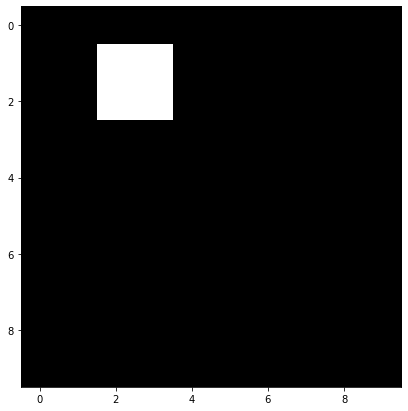

In [3]:
plt.figure(figsize=(15, 7))
plt.imshow(x[0, :, :, :].numpy().transpose((1, 2, 0)))

In [13]:
y_pred_orig = 1.0 * x

# Data augmentation: geom only
k = random.randint(1, 3)
print("k=", k)
x_aug = torch.rot90(x, k=k, dims=(2, 3))
y_pred_orig_aug = torch.rot90(y_pred_orig, k=k, dims=(2, 3))
if random.random() < 0.5:
    print("random flip v")
    x_aug = torch.flip(x_aug, dims=(2, ))
    y_pred_orig_aug = torch.flip(y_pred_orig_aug, dims=(2, )) 
if random.random() < 0.5:
    print("random flip h")
    x_aug = torch.flip(x_aug, dims=(3, ))
    y_pred_orig_aug = torch.flip(y_pred_orig_aug, dims=(3, )) 

y_pred_aug = 1.0 * x_aug

k= 3


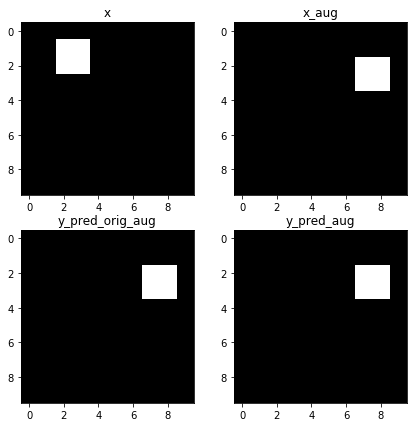

In [14]:
plt.figure(figsize=(7, 7))
plt.subplot(2, 2, 1)
plt.title("x")
plt.imshow(x[0, :, :, :].numpy().transpose((1, 2, 0)))
plt.subplot(2, 2, 2)
plt.title("x_aug")
plt.imshow(x_aug[0, :, :, :].numpy().transpose((1, 2, 0)))
plt.subplot(2, 2, 3)
plt.title("y_pred_orig_aug")
plt.imshow(y_pred_orig_aug[0, :, :, :].numpy().transpose((1, 2, 0)))
plt.subplot(2, 2, 4)
plt.title("y_pred_aug")
plt.imshow(y_pred_aug[0, :, :, :].numpy().transpose((1, 2, 0)))

Check training

- change kernel to one used for mlflow runs

In [1]:
import sys
sys.path.insert(0, "../code")
sys.path.insert(0, "../")

In [16]:
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
import os

os.environ['MASTER_ADDR'] = "localhost"
os.environ['MASTER_PORT'] = "2222"
os.environ['RANK'] = "0"
os.environ['WORLD_SIZE'] = "1"

In [3]:
import torch
import torch.distributed as dist


assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled, "Nvidia/Amp requires cudnn backend to be enabled."

dist.init_process_group("nccl", init_method="env://")

In [4]:
from collections.abc import Mapping
from pathlib import Path

import random

import torch
import torch.distributed as dist
from torch.utils.data import DataLoader

from apex import amp
from apex.parallel import DistributedDataParallel as DDP

import ignite
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.utils import convert_tensor
from ignite.metrics import Fbeta, IoU, ConfusionMatrix, mIoU
from ignite.metrics.confusion_matrix import cmAccuracy, cmPrecision, cmRecall
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.engines import common

from py_config_runner.config_utils import get_params, TRAINVAL_CONFIG, assert_config
from py_config_runner.utils import set_seed

from utils.handlers import predictions_gt_images_handler

In [5]:
import os
os.environ['INPUT_PATH'] = "../input/"

In [6]:
from configs.train.uda import baseline_se_resnext50_FPN_on_db as config

In [7]:
local_rank = 0
with_pbar_on_iters = True


if not getattr(config, "use_fp16", True):
    raise RuntimeError("This training script uses by default fp16 AMP")

set_seed(config.seed + local_rank)
torch.cuda.set_device(local_rank)
device = 'cuda'

torch.backends.cudnn.benchmark = True

train_loader = config.train_loader
train_sampler = getattr(train_loader, "sampler", None)
assert train_sampler is not None, "Train loader of type '{}' " \
                                  "should have attribute 'sampler'".format(type(train_loader))
# assert hasattr(train_sampler, 'set_epoch') and callable(train_sampler.set_epoch), \
#     "Train sampler should have a callable method `set_epoch`"

unsup_train_loader = config.unsup_train_loader
unsup_train_sampler = getattr(unsup_train_loader, "sampler", None)
assert unsup_train_sampler is not None, "Train loader of type '{}' " \
                                  "should have attribute 'sampler'".format(type(unsup_train_loader))
# assert hasattr(unsup_train_sampler, 'set_epoch') and callable(unsup_train_sampler.set_epoch), \
#     "Unsupervised train sampler should have a callable method `set_epoch`"

train_eval_loader = config.train_eval_loader
val_loader = config.val_loader

model = config.model.to(device)
optimizer = config.optimizer
model, optimizer = amp.initialize(model, optimizer, opt_level=getattr(config, "fp16_opt_level", "O2"), num_losses=1)
model = DDP(model, delay_allreduce=True)

criterion = config.criterion.to(device)
unsup_criterion = config.unsup_criterion.to(device)

# Setup trainer
prepare_batch = getattr(config, "prepare_batch")
non_blocking = getattr(config, "non_blocking", True)
accumulation_steps = getattr(config, "accumulation_steps", 1)
model_output_transform = getattr(config, "model_output_transform", lambda x: x)

def cycle(seq):
    while True:
        for i in seq:
            yield i

unsup_train_loader_iter = cycle(unsup_train_loader)

def supervised_loss(batch):
    x, y = prepare_batch(batch, device=device, non_blocking=non_blocking)
    y_pred = model(x)
    y_pred = model_output_transform(y_pred)
    loss = criterion(y_pred, y)
    return loss

def unsupervised_loss(batch):
    x = batch['image']
    x = convert_tensor(x, device=device, non_blocking=non_blocking)

    with torch.no_grad():
        y_pred_orig = model(x)

        # Data augmentation: geom only
        k = random.randint(1, 3)
        x_aug = torch.rot90(x, k=k, dims=(2, 3))
        y_pred_orig_aug = torch.rot90(y_pred_orig, k=k, dims=(2, 3))
        if random.random() < 0.5:
            x_aug = torch.flip(x_aug, dims=(2, ))
            y_pred_orig_aug = torch.flip(y_pred_orig_aug, dims=(2, )) 
        if random.random() < 0.5:
            x_aug = torch.flip(x_aug, dims=(3, ))
            y_pred_orig_aug = torch.flip(y_pred_orig_aug, dims=(3, )) 

    y_pred_aug = model(x_aug.detach())

    loss = unsup_criterion(y_pred_aug, y_pred_orig_aug.detach())

    return loss

def train_update_function(engine, batch):
    model.train()

    loss = supervised_loss(batch)
    if isinstance(loss, Mapping):
        assert 'supervised batch loss' in loss
        loss_dict = loss
        output = {k: v.item() for k, v in loss_dict.items()}
        loss = loss_dict['supervised batch loss'] / accumulation_steps
    else:
        output = {'supervised batch loss': loss.item()}

    # Difference with original UDA
    # Apply separately grads from supervised/unsupervised parts
    with amp.scale_loss(loss, optimizer, loss_id=0) as scaled_loss:
        scaled_loss.backward()

    if engine.state.iteration % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()

    unsup_batch = next(unsup_train_loader_iter)
    unsup_loss = engine.state.unsup_lambda * unsupervised_loss(unsup_batch)
    unsup_batch = None

    assert isinstance(unsup_loss, torch.Tensor)
    output['unsupervised batch loss'] = unsup_loss.item()

    with amp.scale_loss(unsup_loss, optimizer, loss_id=0) as scaled_loss:
        scaled_loss.backward()

    if engine.state.iteration % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()

    total_loss = loss +  unsup_loss
    output['total batch loss'] = total_loss.item()

    return output


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [8]:
train_loader_iter = iter(train_loader)

In [9]:
batch = next(train_loader_iter)

In [10]:
loss = supervised_loss(batch)
loss

tensor(0.2502, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [39]:
unsup_batch = next(unsup_train_loader_iter)

In [40]:
x = unsup_batch['image']
x = convert_tensor(x, device=device, non_blocking=non_blocking)

with torch.no_grad():
    y_pred_orig = model(x)

    # Data augmentation: geom only
    k = random.randint(1, 3)
    print("k=", k)
    x_aug = torch.rot90(x, k=k, dims=(2, 3))
    y_pred_orig_aug = torch.rot90(y_pred_orig, k=k, dims=(2, 3))
    if random.random() < 0.5:
        print("flip v")
        x_aug = torch.flip(x_aug, dims=(2, ))
        y_pred_orig_aug = torch.flip(y_pred_orig_aug, dims=(2, )) 
    if random.random() < 0.5:
        print("flip h")
        x_aug = torch.flip(x_aug, dims=(3, ))
        y_pred_orig_aug = torch.flip(y_pred_orig_aug, dims=(3, )) 

y_pred_aug = model(x_aug.detach())

k= 2
flip v
flip h


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 10.91 GiB total capacity; 10.03 GiB already allocated; 21.50 MiB free; 347.07 MiB cached)

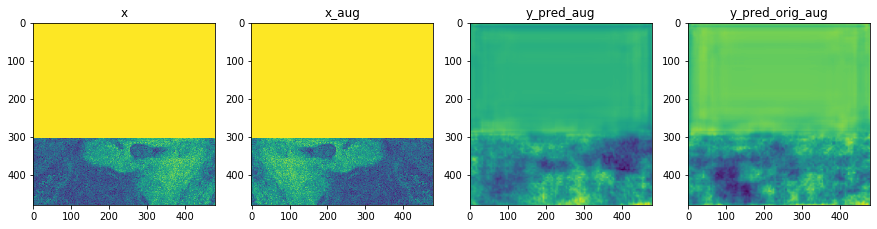

In [38]:
i = 11

plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.title("x")
plt.imshow(x[i, 2, :, :].cpu().detach().numpy())
plt.subplot(142)
plt.title("x_aug")
plt.imshow(x_aug[i, 2, :, :].cpu().detach().numpy())
plt.subplot(143)
plt.title("y_pred_aug")
plt.imshow(y_pred_aug[i, 1, :, :].cpu().detach().numpy())
plt.subplot(144)
plt.title("y_pred_orig_aug")
plt.imshow(y_pred_orig_aug[i, 1, :, :].cpu().detach().numpy())